In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from utils import *

PATH = os.getcwd()

In [112]:
## Stocks classification (by capitalization)
mrktcap = pd.read_csv(os.path.join(PATH, 'dataSent12_21Good','CompaniesrankedMarketCap.csv'))
mrktcap = mrktcap[mrktcap.country == 'United States'] #Filter to US companies

#Add capitalization size column: small cap: 300*e6 to 2*e9;  mid cap 2e9 to 10e9; big > 10e9 
mrktcap['capsize'] = np.where(
    mrktcap['marketcap'].between(300000000, 2000000000), 'small', np.where(
    mrktcap['marketcap'].between(2000000001, 10000000000), 'mid', np.where(
    mrktcap['marketcap'] > 10000000000, 'big' , ''))) 

mrktcap.head()

,Rank,Name,Symbol,marketcap,price (USD),country,capsize
0,1,Apple,AAPL,2703284502528,163.76,United States,big
1,2,Microsoft,MSFT,2478232567808,329.49,United States,big
2,3,Alphabet (Google),GOOG,1876099203072,2875.53,United States,big
4,5,Amazon,AMZN,1743250259968,3437.36,United States,big
5,6,Tesla,TSLA,1099665113088,1084.60,United States,big


In [113]:
## The sentiment dataset is in long format, with each column being a different sentiment indicator.
# We create a table for each sentiment indicator, and pivot them to into familiar wide format:
# Each table will align all stocks by date and those which has no data for given date will be fill with NaN

#1. Grab sentiments
big_sent_all = pd.read_csv(os.path.join(PATH, 'dataSent12_21Good', 'USbig_Sent12_21.csv'))
big_sent_all['date'] = pd.to_datetime(big_sent_all['date']).dt.date

#2. Make a table for each sentiment indicator
big_sent_tables = {}
for i in big_sent_all.columns[2:]:   
    big_sent_pivot = big_sent_all.pivot(index="date", columns="stock", values= i)
    big_sent_tables['big_'+i] = big_sent_pivot
    
print('List of tables created: ',big_sent_tables.keys())
print('RCV Table:')
big_sent_tables['big_RCV'].head()

List of tables created:  dict_keys(['big_RCV', 'big_RVT', 'big_positivePartscr', 'big_negativePartscr', 'big_splogscr', 'big_linscr'])
RCV Table:


stock,AAL,AAPL,ABBV,ABC,ABT,ADP,AIG,AMD,AMZN,AXP,...,UAL,UNH,UPS,USB,V,VZ,WFC,WMT,WY,XOM
date,,,,,,,,,,,,,,,,,,,,,
2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
2012-01-03,NaN,0.000,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,...,2.632,NaN,NaN,0.000,NaN,0.000,0.000,0.000,NaN,33.333
2012-01-04,0.000,41.667,NaN,44.444,-14.286,0.000,0.000,0.000,0.000,0.000,...,47.692,0.000,0.000,30.000,0.000,22.222,0.000,37.500,0.0,43.478
2012-01-05,25.000,45.455,NaN,0.000,33.333,38.889,13.333,-7.692,4.167,-9.091,...,38.571,0.000,25.000,57.333,38.462,49.383,51.852,48.148,-20.0,38.889
2012-01-06,46.666,45.395,NaN,-33.333,-73.333,57.384,-60.000,-43.750,41.935,-35.714,...,26.250,33.335,-57.142,27.941,-28.571,14.706,36.765,54.412,NaN,20.000


In [114]:
#Same procedure for mid and small-cap

#Mid companies
mid_sent_all = pd.read_csv(os.path.join(PATH, 'dataSent12_21Good', 'USmed_Sent12_21.csv'))
mid_sent_all['date'] = pd.to_datetime(mid_sent_all['date']).dt.date
mid_sent_tables = {}
for i in mid_sent_all.columns[2:]:   
    mid_sent_pivot = mid_sent_all.pivot(index="date", columns="stock", values= i)
    mid_sent_tables['mid_'+i] = mid_sent_pivot
       
#Small companies
small_sent_all = pd.read_csv(os.path.join(PATH, 'dataSent12_21Good', 'USsmall_Sent12_21.csv'))
small_sent_all['date'] = pd.to_datetime(small_sent_all['date']).dt.date
small_sent_tables = {}
for i in small_sent_all.columns[2:]:   
    small_sent_pivot = small_sent_all.pivot(index="date", columns="stock", values= i)
    small_sent_tables['small_'+i] = small_sent_pivot

In [115]:
print("Number of Big sized companies: ",len(big_sent_tables['big_RCV'].columns))
print("Number of Medium sized companies: ",len(mid_sent_tables['mid_RCV'].columns))
print("Number of Small sized companies: ", len(small_sent_tables['small_RCV'].columns))

Number of Big sized companies:  108
Number of Medium sized companies:  31
Number of Small sized companies:  12


We check viable stocks with less than 20% missing values. We note that there aren't many (28) from the original 108. Next we want to know if we remove some consecutive early years, we get a lower proportion of NaN's.

In [116]:
get_viable_stocks(big_sent_tables['big_RCV'], 0.2).shape

(28,)

By removing the first 3 years we only improve by one stocks, which means that the missing values are relatively uniformlly distributed.

In [117]:
remove_years(big_sent_tables['big_RCV'], 3, 0.2).shape

(30,)

We could be more flexible with our tolerance for NaNs and cosider stocks with at most 25% which brings us up to 44.

In [118]:
remove_years(big_sent_tables['big_RCV'], 0,0.25).shape

(44,)

We also want to check if at any given year there were more than 20% or 25% NaN's so we could only select the stocks that make sense. There are only 24 of these. This means that we need to either relax our missing data threshold or only work on fullish stocks. Notice that this is for big companies, smaller companies have less information.

In [119]:
viable_years(big_sent_tables['big_RCV'], 0.25).shape

(24,)

In [120]:
print("Viable stocks for Medium sized companies: ", len(get_viable_stocks(mid_sent_tables['mid_RCV'], 0.2)))
print("Viable stocks for Small sized companies: ", len(get_viable_stocks(small_sent_tables['small_RCV'], 0.2)))

Viable stocks for Medium sized companies:  3
Viable stocks for Small sized companies:  3


In [121]:
two = get_weekly_stocks(big_sent_tables['big_RCV'], 2) > 80
two.mean()*100


63.26923076923077

Red dotted line is at 80 viable stocks. The volume of viable stocks represents the count (ie how many weeks we have x amount of viable stocks). 

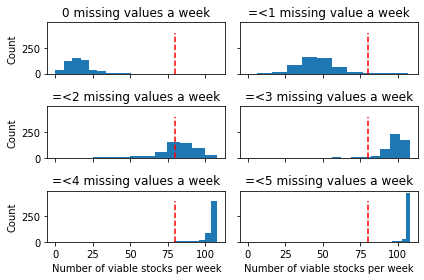

In [122]:
plothist(big_sent_tables['big_RCV'], 80)

In [123]:
percent_above(big_sent_tables['big_RCV'], 80)

If we allow 0 or less NaN's we get 0.0 percent of weeks with more than 80 viable stocks
If we allow 1 or less NaN's we get 2.1153846153846154 percent of weeks with more than 80 viable stocks
If we allow 2 or less NaN's we get 63.26923076923077 percent of weeks with more than 80 viable stocks
If we allow 3 or less NaN's we get 95.76923076923077 percent of weeks with more than 80 viable stocks
If we allow 4 or less NaN's we get 99.42307692307692 percent of weeks with more than 80 viable stocks
If we allow 5 or less NaN's we get 100.0 percent of weeks with more than 80 viable stocks
